## `**Relation Extraction Bi-LSTM**`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/snips_nlu
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [3]:
%tensorflow_version 1.x
%cd /content/drive/MyDrive/snips_nlu

/content/drive/MyDrive/snips_nlu


150
Maximum sequence length: 147


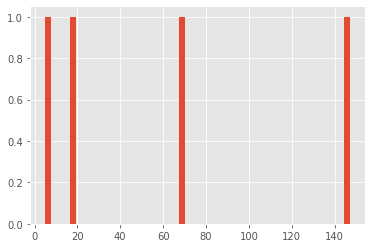

Word          ,(relation), word
( base64       ), has_argument,  ClASS
( json         ), has_type,  ClASS
( logging      ), has_value,  Method
( math         ), has_argument,  Method
( os           ), has_type,  Method
( shutil       ), has_value,  Method
( tempfile     ), has_argument,  Method
( CRFSlotFiller), has_type,  Method
( _get_crf_model), has_value,  Func_Call
( _encode_tag  ), has_argument,  Func_Call
( _decode_tag  ), has_type,  Func_Call
( _crf_model_from_path), has_value,  Func_Call
( _ensure_safe ), has_argument,  Func_Call
( _weight_absolute_value), has_type,  Func_Call
( model.crfsuite), has_value,  Func_Call
( __init__     ), has_argument,  Func_Call
( features     ), has_type,  Func_Call
( labels       ), has_value,  String
( fitted       ), has_argument,  Library
( fit          ), has_type,  Library
( get_slots    ), has_value,  ClASS
( compute_features), has_argument,  Method
( get_sequence_probability), has_type,  Method
( _get_sequence_probability), has_argument,

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')
import sys
import json as json
import ast
import os
import io
import glob
from csv import writer 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k

# cd /content/drive/MyDrive/snips_nlu

df = pd.read_csv("/content/drive/MyDrive/snips_nlu/Relation_data.csv", encoding="utf-8", sep=',')
# df['relation'].value_counts()
data = df[['code_index','word','label','relation']]
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["relation"].values.tolist())]
        self.grouped = self.dataset.groupby("code_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences   

from math import nan

words = list(set(data["word"].values))
labels = list(set(data["label"]))
n_words = len(words)
tags = []
for tag in set(data["relation"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('O')
    else:
        tags.append(tag)
n_tags = len(tags)

from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}
print(len(word2idx))

maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

maxlen = max([len(s) for s in sentences])

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[t[1]] for t in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=n_tags-1)
y = [to_categorical(i, num_classes=n_tags) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

# input = Input(shape=(147,))
# word_embedding_size = 150

# # Embedding Layer
# model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=147)(input)

# # BI-LSTM Layer
# model = Bidirectional(LSTM(units=word_embedding_size, 
#                            return_sequences=True, 
#                            dropout=0.5, 
#                            recurrent_dropout=0.5, 
#                            kernel_initializer=k.initializers.he_normal()))(model)
# model = LSTM(units=word_embedding_size * 2, 
#              return_sequences=True, 
#              dropout=0.5, 
#              recurrent_dropout=0.5, 
#              kernel_initializer=k.initializers.he_normal())(model)

# # TimeDistributed Layer
# model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# # CRF Layer
# crf = CRF(n_tags)

# out = crf(model)  # output
# model = Model(input, out)
# from keras.callbacks import ModelCheckpoint
# import matplotlib.pyplot as plt
# import numpy as np
# from keras.layers import add
# #Optimiser 
# adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# # Compile model
# model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

# model.summary()

# Saving the best model only
filepath="saved_model/Relext-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.2, verbose=1, callbacks=callbacks_list)

model.predict(X_test)

TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1

i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
gt = np.argmax(y_test[i], axis=-1)
ll = data['label']
print("{:14},({:5}), {}".format("Word","relation", "word"))
for idx, (w,pred) in enumerate(zip(X_test[i],p[0],)):
    print("({:14}), {:5}, {}".format(words[w],tags[pred], ll[idx],))
p = model.predict(np.array(X_test)) 
from sklearn.metrics import classification_report
np.argmax(p, axis=2)[0]
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.style.use("ggplot")
# x =classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values()))
# plt.hist(x, bins=50,orientation='horizontal')
# plt.show()